In [11]:
from k_discount_var import kDISCount
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
import seaborn as sns
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import warnings
warnings.filterwarnings('ignore')

In [12]:
model_name = 'clip-ViT-L-14'
model = SentenceTransformer(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [88]:
def generate_probs(query, temperature):
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    cos_sims = util.cos_sim(img_emb, query_emb) / temperature
    probabilities = np.array(F.softmax(cos_sims, dim=0).cpu().numpy().flatten())
    return probabilities

def generate_gt(label, type_of_query):
    if type_of_query == 'direct':
        img_emb = torch.load(f'{model_name}_CUB.pt', map_location=device)
        num_images = len(img_emb)
        with open('img_names.pkl', 'rb') as f:
            img_names = pickle.load(f)
        
        f = np.zeros(num_images)
        
        bird_type = label
        
        for i, img in enumerate(img_names):
            if bird_type.lower() in img.lower(): f[i] = 1
        print(f'Positives: {sum(f)}')
        print('-----------------------------------------')
        return f, img_emb, num_images
        
    elif type_of_query == 'attribute':
        img_emb = torch.load(f'{model_name}_CUB_F.pt', map_location=device)
        num_images = len(img_emb)
        attributes_path = 'attributes.txt'
        entries_path = 'image_attribute_labels.txt'

        attribute_name = label

        attribute_number = []
        with open(attributes_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if attribute_name in parts[1]:
                    attribute_number.append(int(parts[0]))

        if attribute_number is None:
            raise ValueError(f"Attribute '{attribute_name}' not found")

        print(f'Attribute Number(s): {attribute_number}')

        image_indices = set()
        with open(entries_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                image_number, attr_num, value = int(parts[0]), int(parts[1]), int(parts[2])
                if attr_num in attribute_number and value == 1:
                    image_indices.add(image_number - 1)

        idx = list(image_indices)
        f = np.zeros(num_images)
        f[idx] = 1
        print(f'Positives: {sum(f)}')
        print('-----------------------------------------')
        return f, img_emb, num_images

In [89]:
# CHOOSE TYPE OF QUERY - 'direct' for class name level classification and 'attribute' for attribute level
type_of_query = 'direct'

# Ground truth generation - ONLY if the query is an attribute
# label = 'has_primary_color::yellow'
# type_of_query = 'attribute'

def get_random_lines(filename, num_lines):
    with open(filename, 'r') as file:
        total_lines = sum(1 for line in file)
    
    # Get a random sample of line numbers
    selected_line_numbers = np.random.choice(total_lines, num_lines, replace=False)
    selected_line_numbers.sort() 

    selected_lines = []
    with open(filename, 'r') as file:
        for i, line in enumerate(file):
            if i in selected_line_numbers:
                selected_lines.append(line.strip())
            if len(selected_lines) == num_lines:
                break

    return selected_lines

def read_classes_from_lines(lines):
    classes_and_queries = []
    for line in lines:
        class_name = line.split('.')[1]
        query_name = class_name.replace('_', ' ')
        classes_and_queries.append((class_name, f"A photo of a {query_name}"))
    return classes_and_queries

# Number of queries to select
num_queries = 20
random_lines = get_random_lines('classes.txt', num_queries)
classes_and_queries = read_classes_from_lines(random_lines)
print(classes_and_queries)

[('Groove_billed_Ani', 'A photo of a Groove billed Ani'), ('Red_winged_Blackbird', 'A photo of a Red winged Blackbird'), ('Northern_Flicker', 'A photo of a Northern Flicker'), ('Horned_Grebe', 'A photo of a Horned Grebe'), ('Western_Grebe', 'A photo of a Western Grebe'), ('Evening_Grosbeak', 'A photo of a Evening Grosbeak'), ('California_Gull', 'A photo of a California Gull'), ('Rufous_Hummingbird', 'A photo of a Rufous Hummingbird'), ('Pomarine_Jaeger', 'A photo of a Pomarine Jaeger'), ('Green_Jay', 'A photo of a Green Jay'), ('Dark_eyed_Junco', 'A photo of a Dark eyed Junco'), ('Nighthawk', 'A photo of a Nighthawk'), ('Clark_Nutcracker', 'A photo of a Clark Nutcracker'), ('Savannah_Sparrow', 'A photo of a Savannah Sparrow'), ('Yellow_throated_Vireo', 'A photo of a Yellow throated Vireo'), ('Cape_May_Warbler', 'A photo of a Cape May Warbler'), ('Orange_crowned_Warbler', 'A photo of a Orange crowned Warbler'), ('Northern_Waterthrush', 'A photo of a Northern Waterthrush'), ('Red_headed_

In [61]:


# # Ground truth generation - ONLY if the query is a species (class)
# label = 'Horned_Lark'
# type_of_query = 'direct'

In [90]:
def train_logreg(
    x_train,
    y_train,
    X_predict,
    y_predict,
    n_epochs=10,
    weight_decay=1e-1,
    lr=1.0e-2,
):
    x_train = torch.tensor(x_train).float().to(device)
    y_train = torch.tensor(y_train).long().to(device)
    X_predict = torch.tensor(X_predict).float().to(device)
    y_predict = torch.tensor(y_predict).long().to(device)

    # Define the model dimension and send the model to the device
    d = x_train.shape[1]
    model = nn.Linear(d, 2).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay, lr=lr)
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            with torch.no_grad():
                predicted_classes = torch.argmax(outputs, dim=1)
                precision = precision_score(y_train.cpu(), predicted_classes.cpu(), zero_division=0)
                recall = recall_score(y_train.cpu(), predicted_classes.cpu())
                # print(f"Epoch {epoch + 1}: Precision = {precision:.4f}, Recall = {recall:.4f} (on test)")

    model.eval()
    with torch.no_grad():
        outputs = model(X_predict)
        predicted_classes = torch.argmax(outputs, dim=1)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy()

    # cm = confusion_matrix(y_predict.cpu().numpy(), predicted_classes.cpu().numpy())
    return probs

def sufficient_samples(labels, minimum_count=2):
    unique, counts = np.unique(labels, return_counts=True)
    label_counts = dict(zip(unique, counts))
    return all(count >= minimum_count for count in label_counts.values())

In [91]:
# Define hyperparameters
eps = 1e-4
temperatures = np.array([0.1])
reg = 0.001 if type_of_query == 'direct' else 0.1  # Regularization term for the linear classifier
weights = 'var' if type_of_query == 'direct' else 'split'
split_values = np.array([0.5])
dataset_size = generate_gt('','')
num_images = len(torch.load(f'{model_name}_CUB.pt', map_location=device))
percentages = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
n_values = (percentages / 100 * num_images).astype(int)
repetitions = 100

all_results = {
    'DISCount': [],
    'Uniform': [],
    'Adaptive': {split: [] for split in split_values}
}

In [92]:
for class_name, query in classes_and_queries:
    print(f"Query: {query}")

    f, img_emb, num_images = generate_gt(class_name, type_of_query)
    
    ground_truth = sum(f)

    # Uniform
    g_uni = np.full(num_images, 1 / num_images)

    # Initialize data structures to store results
    mean_percentage_errors = {temp: [] for temp in temperatures}
    mean_percentage_error_lower_bounds = {temp: [] for temp in temperatures}
    mean_percentage_error_upper_bounds = {temp: [] for temp in temperatures}

    # Adaptive estimator results initialized for each temperature
    AS_results = {
        split: {
            temp: {
                'mean_percentage_errors_AS': [],
                'mean_percentage_error_lower_bounds_AS': [],
                'mean_percentage_error_upper_bounds_AS': [],
            } for temp in temperatures
        } for split in split_values
    }

    # Uniform estimator results
    mean_percentage_errors_UNI = []
    mean_percentage_error_lower_bounds_UNI = []
    mean_percentage_error_upper_bounds_UNI = []

    for n in n_values:
        print(f'Processing n={n}')
        
        for temp in temperatures:
            
            # DISCount setup for current temperature
            percentage_errors_temp = []
            percentage_error_lower_bounds_temp = []
            percentage_error_upper_bounds_temp = []

            # Repeat for uniform estimator
            percentage_errors_UNI_temp = []
            percentage_error_lower_bounds_UNI_temp = []
            percentage_error_upper_bounds_UNI_temp = []
        
            g = generate_probs(query, temp)  # Generate probability distribution for current temperature
        
            for split in split_values:

                # Adaptive Sampling setup for current temperature
                percentage_errors_AS_temp = []
                percentage_error_lower_bounds_AS_temp = []
                percentage_error_upper_bounds_AS_temp = []
            
                for _ in tqdm.tqdm(range(repetitions), desc=f'AS: Temperature {temp}, Split {split}'):
                    
                    n_split = int(n*split)
                            
                    estimator_AS = kDISCount(g, g, eps)  # Use temperature-based proposal for AS
                    samples_as = estimator_AS.sample(n=n_split)
                    screened_samples_as = [f[i] for i in samples_as]
                    if not sufficient_samples(screened_samples_as): 
                        # print('Insufficient Positive/Negative Samples, skipping')
                        continue
                    estimator_AS.load(screened_samples_as)
                    F_hat_temp, CI_temp, Var_hat_temp = estimator_AS.estimate([[i for i, _ in enumerate(g)]])
                    estimate_pre = F_hat_temp[0]
                    variance_pre = Var_hat_temp[0]
                    
                    X_train = img_emb[samples_as]
                    y_train = np.array(f[samples_as])

                    all_indices = np.arange(len(g))
                    unscreend_indices = np.setdiff1d(all_indices, samples_as)
                    X_predict = img_emb[unscreend_indices]
                    y_predict = f[unscreend_indices]

                    all_indices = np.arange(len(g))
                    unscreend_indices = np.setdiff1d(all_indices, samples_as)

                    # Get predictions (probabilities)
                    predictions_unscreend = train_logreg(X_train, y_train, X_predict, y_predict, weight_decay=reg, n_epochs=1000)
            
                    # Continue with the modified predictions
                    new_g = np.array([None] * len(g))
                    for idx, actual_value in zip(samples_as, screened_samples_as):
                        new_g[idx] = actual_value
                    for idx, pred_value in zip(unscreend_indices, predictions_unscreend):
                        new_g[idx] = pred_value
                        
                    new_g = (new_g).astype(float)
                    new_g += eps
                    norm = new_g.sum()
                    new_g = new_g/norm
        
                    estimator_linear = kDISCount(new_g, new_g, eps)
                    n_linear = n - n_split
                    samples_linear = estimator_linear.sample(n = n_linear)
                    screened_samples_linear = [f[i] for i in samples_linear]
                    estimator_linear.load(screened_samples_linear)
                    F_hat_temp, CI_temp, Var_hat_temp = estimator_linear.estimate([[i for i, _ in enumerate(new_g)]])
                    estimate_post = F_hat_temp[0]
                    variance_post = Var_hat_temp[0]
                    
                    if weights == 'var':
                        # Variance based weights
                        weight1 = 1 / variance_pre
                        weight2 = 1 / variance_post
                        estimate_weighted = (weight1 * estimate_pre + weight2 * estimate_post) / (weight1 + weight2)  
            
                    elif weights == 'split':
                        # Sample-ratio based weights (pick one)
                        estimate_weighted = split*estimate_pre + (1-split)*estimate_post
                    
                    perc_error_AS = abs(estimate_weighted - ground_truth) / ground_truth * 100
                    # perc_error_lb_AS = abs(estimate_weighted - CI_temp[0] - ground_truth) / ground_truth * 100
                    # perc_error_ub_AS = abs(estimate_weighted + CI_temp[0] - ground_truth) / ground_truth * 100

                    percentage_errors_AS_temp.append(perc_error_AS)
                    # percentage_error_lower_bounds_AS_temp.append(perc_error_lb_AS)
                    # percentage_error_upper_bounds_AS_temp.append(perc_error_ub_AS)
                
                # Store mean errors for AS at current temperature
                AS_results[split][temp]['mean_percentage_errors_AS'].append(np.nanmean(percentage_errors_AS_temp))
                # AS_results[split][temp]['mean_percentage_error_lower_bounds_AS'].append(np.nanmean(percentage_error_lower_bounds_AS_temp))
                # AS_results[split][temp]['mean_percentage_error_upper_bounds_AS'].append(np.nanmean(percentage_error_upper_bounds_AS_temp))
        
            
            for _ in tqdm.tqdm(range(repetitions), desc=f'DIS: Temperature {temp}'):

                estimator_temp = kDISCount(g, g, eps)
                samples_temp = estimator_temp.sample(n=n)
                screened_samples_temp = [f[i] for i in samples_temp]
                estimator_temp.load(screened_samples_temp)
                F_hat_temp, CI_temp, Var_hat_temp = estimator_temp.estimate([[i for i, _ in enumerate(g)]])

                # Calculate errors for temperature-based estimation
                perc_error_temp = abs(F_hat_temp[0] - ground_truth) / ground_truth * 100
                # perc_error_lb_temp = abs(F_hat_temp[0] - CI_temp[0] - ground_truth) / ground_truth * 100
                # perc_error_ub_temp = abs(F_hat_temp[0] + CI_temp[0] - ground_truth) / ground_truth * 100

                percentage_errors_temp.append(perc_error_temp)
                # percentage_error_lower_bounds_temp.append(perc_error_lb_temp)
                # percentage_error_upper_bounds_temp.append(perc_error_ub_temp)

            # Store mean errors for current temperature
            mean_percentage_errors[temp].append(np.nanmean(percentage_errors_temp))
            # mean_percentage_error_lower_bounds[temp].append(np.nanmean(percentage_error_lower_bounds_temp))
            # mean_percentage_error_upper_bounds[temp].append(np.nanmean(percentage_error_upper_bounds_temp))


        for _ in tqdm.tqdm(range(repetitions), desc='Uniform'):

            estimator_UNI = kDISCount(g_uni, g_uni, eps)
            samples_uni = estimator_UNI.sample(n=n)
            screened_samples_uni = [f[i] for i in samples_uni]
            estimator_UNI.load(screened_samples_uni)
            F_hat_uni, CI_uni, Var_hat_uni = estimator_UNI.estimate([[i for i, _ in enumerate(g)]])

            perc_error_UNI = abs(F_hat_uni[0] - ground_truth) / ground_truth * 100
            # perc_error_lb_UNI = abs(F_hat_uni[0] - CI_uni[0] - ground_truth) / ground_truth * 100
            # perc_error_ub_UNI = abs(F_hat_uni[0] + CI_uni[0] - ground_truth) / ground_truth * 100

            percentage_errors_UNI_temp.append(perc_error_UNI)
            # percentage_error_lower_bounds_UNI_temp.append(perc_error_lb_UNI)
            # percentage_error_upper_bounds_UNI_temp.append(perc_error_ub_UNI)

        # Store mean errors for uniform estimator
        mean_percentage_errors_UNI.append(np.nanmean(percentage_errors_UNI_temp))
        # mean_percentage_error_lower_bounds_UNI.append(np.nanmean(percentage_error_lower_bounds_UNI_temp))
        # mean_percentage_error_upper_bounds_UNI.append(np.nanmean(percentage_error_upper_bounds_UNI_temp))
    
    all_results['DISCount'].append(mean_percentage_errors[temperatures[0]])
    all_results['Uniform'].append(mean_percentage_errors_UNI)
    for split in split_values:
        all_results['Adaptive'][split].append(AS_results[split][temperatures[0]]['mean_percentage_errors_AS'])
    print('-----------------------------------------')
    

AS: Temperature 0.1, Split 0.5:   0%|          | 0/100 [00:00<?, ?it/s]

Query: A photo of a Groove billed Ani
Positives: 60.0
-----------------------------------------
Processing n=117


AS: Temperature 0.1, Split 0.5:   0%|          | 0/100 [00:00<?, ?it/s]

Processing n=235


AS: Temperature 0.1, Split 0.5:   0%|          | 0/100 [00:00<?, ?it/s]

Processing n=353


AS: Temperature 0.1, Split 0.5:   0%|          | 0/100 [00:00<?, ?it/s]

Processing n=471


AS: Temperature 0.1, Split 0.5:  98%|█████████▊| 98/100 [02:36<00:02,  1.46s/it]

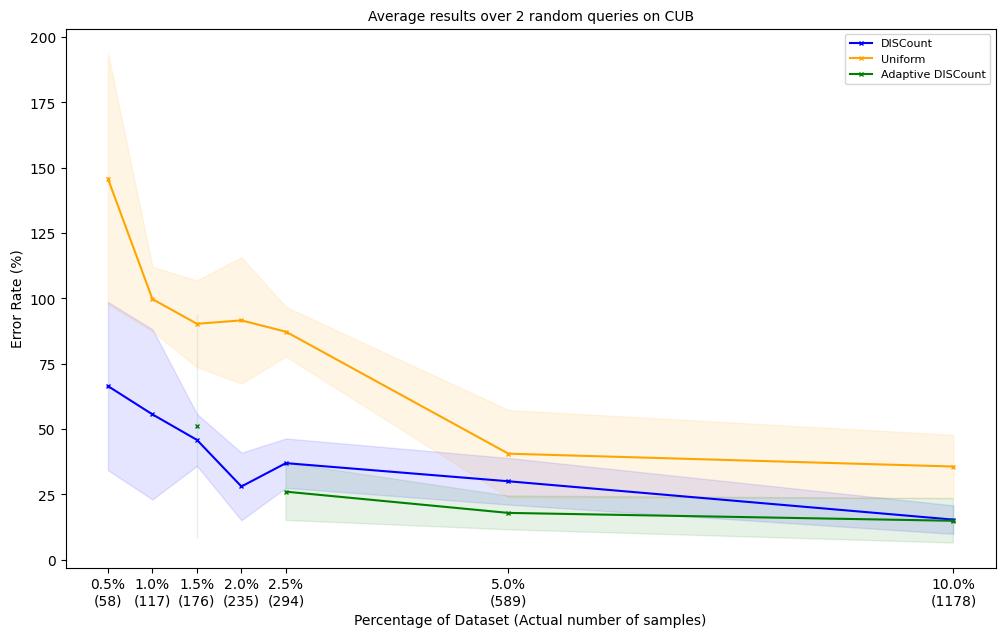

In [59]:
avg_results = {
    'DISCount': np.mean(all_results['DISCount'], axis=0),
    'Uniform': np.mean(all_results['Uniform'], axis=0),
    'Adaptive': {split: np.mean(all_results['Adaptive'][split], axis=0) for split in split_values}
}

std_results = {
    'DISCount': np.std(all_results['DISCount'], axis=0),
    'Uniform': np.std(all_results['Uniform'], axis=0),
    'Adaptive': {split: np.std(all_results['Adaptive'][split], axis=0) for split in split_values}
}

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))

num_splits = len(split_values)
colors_adaptive = plt.cm.Greens(np.linspace(0.35, 0.75, num_splits))

# Plot DISCount
ax.plot(percentages, avg_results['DISCount'], label='DISCount', color='blue', marker='x', markersize=3, linestyle='-')
ax.fill_between(percentages, 
                avg_results['DISCount'] - std_results['DISCount'],
                avg_results['DISCount'] + std_results['DISCount'],
                alpha=0.1, color='blue')

# Plot Uniform
ax.plot(percentages, avg_results['Uniform'], label='Uniform', color='orange', marker='x', markersize=3, linestyle='-')
ax.fill_between(percentages, 
                avg_results['Uniform'] - std_results['Uniform'],
                avg_results['Uniform'] + std_results['Uniform'],
                alpha=0.1, color='orange')

# Plot Adaptive
for j, split in enumerate(split_values):
    ax.plot(percentages, avg_results['Adaptive'][split], 
            label=f'Adaptive DISCount', color='green', marker='x', markersize=3, linestyle='-')
    ax.fill_between(percentages, 
                    avg_results['Adaptive'][split] - std_results['Adaptive'][split],
                    avg_results['Adaptive'][split] + std_results['Adaptive'][split],
                    alpha=0.1, color='green')

ax.set_xlabel('Percentage of Dataset (Actual number of samples)')
ax.set_ylabel('Error Rate (%)')
ax.set_title(f"Direct Classification Queries on CUB", fontsize=10)
ax.legend(loc='upper right', fontsize=8)

# Customize x-axis ticks to show both percentage and actual number
def format_func(value, tick_number):
    percentage = value  # Keep as float
    index = np.argmin(np.abs(percentages - percentage))
    actual_number = n_values[index]
    return f"{percentage:.1f}%\n({actual_number})"

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.set_xticks(percentages)

plt.tight_layout()
# Add caption
caption = """This plot shows the error rates and standard deviations averaged over 100 runs of each method for 20 random queries. We randomly sample 20 classnames from the dataset
and generate corresponding queries of the form: 'A photo of a {class name}.' The temperature (value which softmax is divided by) for both DISCount and Adaptive DISCount is set to 0.1,
and the regularization parameter for Adaptive DISCount is set to 1e-4. We perform 1 Adaptive update. 
"""

plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=8)

# Adjust the bottom margin to make room for the caption
plt.subplots_adjust(bottom=0.2)

plt.show()